In [1]:
import pycaret
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from pycaret.classification import setup, compare_models
from pycaret.classification import *
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix

Get test metrics

In [2]:
#Define the target and feature combo for which test metrics is gatheres

itarget = "bcl"         #options: bcl, mcl   
feature = 'md'          #fp, md

In [3]:
#Load train data

file_name = f'../../data_preparation/variable_{feature}_generation/inhibitors_{feature}/inhibitors_{itarget}_{feature}_sub.csv'
df = pd.read_csv(file_name, index_col=0)

In [4]:
df["Class"] = df["Class"].replace({'Inhibitor':1, 'Non-inhibitor':0})

In [5]:
#Clean the dataset
df_train = df.drop(['Unnamed: 0','papyrus_SMILES','InChIKey','connectivity','pchembl_value_Mean'], axis=1)

df_train.head()

,Class,cdk - Fsp3,cdk - nSmallRings,cdk - nAromRings,cdk - nRingBlocks,cdk - nAromBlocks,cdk - nRings3,cdk - nRings4,cdk - nRings5,cdk - nRings6,...,padel - AMW,padel - WTPT-1,padel - WTPT-2,padel - WTPT-3,padel - WTPT-4,padel - WTPT-5,padel - WPATH,padel - WPOL,padel - XLogP,padel - Zagreb
0,0,0.357143,2,2,1,1,0,0,0,2,...,7.545708,37.589600,1.978400,13.240667,13.240667,0.000000,620.0,34.0,3.289,100.0
1,0,0.096774,5,5,3,3,0,0,0,5,...,9.855668,82.222215,2.055555,24.302148,9.973556,8.630671,6055.0,69.0,1.918,212.0
2,1,0.457143,4,3,4,3,0,0,0,4,...,7.339966,96.473195,2.009858,37.448670,15.189713,15.690223,10656.0,76.0,5.537,246.0
3,0,0.000000,3,3,1,1,0,0,0,3,...,9.482858,38.696794,2.036673,12.788935,12.788935,0.000000,600.0,38.0,1.405,106.0
4,0,0.300000,4,2,3,2,0,0,0,4,...,9.015981,78.909859,2.023330,23.409765,15.275357,3.037460,5760.0,66.0,5.029,204.0


In [6]:
#Define evaluation metrics: balanced accuracy, balanced MCC

#Function for balanced accuracy
def balanced_accuracy(y_true, y_pred):
    return balanced_accuracy_score(y_true, y_pred)

#Function for balanced MCC
def balanced_mcc(y_true, y_pred):
    # Get confusion matrix components
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculate sensitivity, specificity, and prevalence
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    positive_prevalence = (TP + FN) / (TP + FP + TN + FN)
    
    # Calculate Balanced MCC
    numerator = sensitivity + specificity - 1
    denominator = np.sqrt(
        (sensitivity + (1-specificity) * ((1-positive_prevalence) / positive_prevalence )) * 
        (specificity + (1-sensitivity) * (positive_prevalence / (1-positive_prevalence)))
    )

    if denominator == 0:
        return 0
    elif numerator == 0:
        return 0
    else:
        return numerator / denominator

In [7]:
model_names = ['XGBClassifier', 'AdaBoostClassifier', 'DecisionTreeClassifier', 'DummyClassifier', 'ExtraTreesClassifier','GaussianNB','GradientBoostingClassifier','KNeighborsClassifier','LGBMClassifier',
              'LinearDiscriminantAnalysis','LogisticRegression','QuadraticDiscriminantAnalysis','RandomForestClassifier','RidgeClassifier','SGDClassifier']

In [8]:
session_ids=[16]

Random split

In [9]:
split = "random"   

In [ ]:
all_metrics = []

# Loop through the session IDs
for model in model_names:
    print(f'Prediction with model: {model}')
    for s_id in session_ids:
        print(f"Setting up PyCaret session: {s_id} -{feature} - {itarget}")

        # Setup the environment with the specific session ID
        grid= setup(df, 
                    target="Class", 
                    session_id=s_id, 
                    html=True, 
                    verbose=False, 
                    fold=5, 
                    data_split_shuffle=True, 
                    remove_multicollinearity=True, 
                    multicollinearity_threshold=0.9, 
                    low_variance_threshold=0.05)
    
        # Add the custom metrics to pycaret
        add_metric('balanced_acc', 'Balanced Accuracy', balanced_accuracy, target='pred')
        add_metric('balanced_mcc', 'Balanced MCC', balanced_mcc, greater_is_better=True, target='pred')
        #add_metric('enrichment_factor_score','Enrichment Factor',_enrichment_factor_score, target='pred_proba')
        #add_metric('bedroc_score','BEDROC',_bedroc_score, target='pred_proba')

        class_model_file = f'models/inhibitors_{itarget}_{split}_{feature}_session_{s_id}'

        class_model = load_model(class_model_file)
        
        predictions = predict_model(class_model, raw_score=True)

     # Collect metrics for this session and model
        session_metrics = pull()
        
        # Add model and session information to the metrics
        session_metrics['Model'] = model
        
        all_metrics.append(session_metrics)

# Create a DataFrame from the list of metrics
metrics_df = pd.concat(all_metrics, ignore_index=True)

#Save the metrics
metrics_filename = f"metrics/{itarget}_{split}_test_raw_metrics_predictions_{feature}.csv"
metrics_df.to_csv(metrics_filename)

Temporal split

In [ ]:
split = 'temporal'

In [ ]:
#Load the train and test data
file_name_train = f'splitted_data/inhibitors_{itarget}_{split}_{feature}_train.csv'
df_train = pd.read_csv(file_name_train, index_col=0)
df_train.reset_index(drop=True, inplace=True)

file_name_test = f'splitted_data/inhibitors_{itarget}_{split}_{feature}_test.csv'
df_test = pd.read_csv(file_name_test,index_col=0)
df_test.reset_index(drop=True, inplace=True)

In [ ]:
#dataframe cleaning for train

columns_to_drop = ['papyrus_SMILES', 'InChIKey', 'inchi_connectivity','pchembl_value_Mean']
df = df_train.drop(columns=columns_to_drop)
testing = df_test.drop(columns=columns_to_drop)


In [ ]:
#classification fix
df['Class'] = df['Class'].replace({'Inhibitor': 1, 'Non-inhibitor': 0})
df['Class'] = df['Class'].astype(int)

testing['Class'] = testing['Class'].replace({'Inhibitor': 1, 'Non-inhibitor': 0})
testing['Class'] = testing['Class'].astype(int)


In [ ]:

all_metrics = []

# Loop through the session IDs
for model in model_names:
    print(f'Prediction with model: {model}')
    for s_id in session_ids:
        print(f"Setting up PyCaret session: {s_id} -{feature} - {itarget} - {split}")

            # Setup the environment with the specific session ID
        grid = setup(data=df, 
                target='Class', 
                session_id=16,
                html=True, 
                verbose=True, 
                fold=5, 
                remove_multicollinearity=True,  
                multicollinearity_threshold=0.9, 
                low_variance_threshold=0.05,
                test_data= testing,
                index=False
        )
    
        # Add the custom metrics to pycaret
        add_metric('balanced_acc', 'Balanced Accuracy', balanced_accuracy, target='pred')
        add_metric('balanced_mcc', 'Balanced MCC', balanced_mcc, greater_is_better=True, target='pred')
        #add_metric('enrichment_factor_score','Enrichment Factor',_enrichment_factor_score, target='pred_proba')
        #add_metric('bedroc_score','BEDROC',_bedroc_score, target='pred_proba')

        class_model_file = f'models/inhibitors_{itarget}_{split}_{feature}_session_{s_id}'

        class_model = load_model(class_model_file)
        
        predictions = predict_model(class_model, raw_score=True)

     # Collect metrics for this session and model
        session_metrics = pull()
        
        # Add model and session information to the metrics
        session_metrics['Model'] = model
        
        all_metrics.append(session_metrics)

# Create a DataFrame from the list of metrics
metrics_df = pd.concat(all_metrics, ignore_index=True)


metrics_filename = f"metrics/{itarget}_{split}_test_raw_metrics_predictions_{feature}.csv"
metrics_df.to_csv(metrics_filename)

Cluster split

In [ ]:
split = "cluster"

In [ ]:
#Load the train and test data
file_name_train = f'splitted_data/inhibitors_{itarget}_{split}_{feature}_train.csv'
df_train = pd.read_csv(file_name_train, index_col=0)
df_train.reset_index(drop=True, inplace=True)

file_name_test = f'splitted_data/inhibitors_{itarget}_{split}_{feature}_test.csv'
df_test = pd.read_csv(file_name_test,index_col=0)
df_test.reset_index(drop=True, inplace=True)

In [ ]:
#dataframe cleaning for train

columns_to_drop = ['papyrus_SMILES', 'InChIKey', 'inchi_connectivity','pchembl_value_Mean']
df = df_train.drop(columns=columns_to_drop)
testing = df_test.drop(columns=columns_to_drop)


In [ ]:
#classification fix
df['Class'] = df['Class'].replace({'Inhibitor': 1, 'Non-inhibitor': 0})
df['Class'] = df['Class'].astype(int)

testing['Class'] = testing['Class'].replace({'Inhibitor': 1, 'Non-inhibitor': 0})
testing['Class'] = testing['Class'].astype(int)


In [ ]:

all_metrics = []

# Loop through the session IDs
for model in model_names:
    print(f'Prediction with model: {model}')
    for s_id in session_ids:
        print(f"Setting up PyCaret session: {s_id} -{feature} - {itarget} - {split}")

            # Setup the environment with the specific session ID
        grid = setup(data=df, 
                target='Class', 
                session_id=16,
                html=True, 
                verbose=True, 
                fold=5, 
                remove_multicollinearity=True,  
                multicollinearity_threshold=0.9, 
                low_variance_threshold=0.05,
                test_data= testing,
                index=False
        )
    
        # Add the custom metrics to pycaret
        add_metric('balanced_acc', 'Balanced Accuracy', balanced_accuracy, target='pred')
        add_metric('balanced_mcc', 'Balanced MCC', balanced_mcc, greater_is_better=True, target='pred')
        #add_metric('enrichment_factor_score','Enrichment Factor',_enrichment_factor_score, target='pred_proba')
        #add_metric('bedroc_score','BEDROC',_bedroc_score, target='pred_proba')

        class_model_file = f'models/inhibitors_{itarget}_{split}_{feature}_session_{s_id}'

        class_model = load_model(class_model_file)
        
        predictions = predict_model(class_model, raw_score=True)

     # Collect metrics for this session and model
        session_metrics = pull()
        
        # Add model and session information to the metrics
        session_metrics['Model'] = model
        
        all_metrics.append(session_metrics)

# Create a DataFrame from the list of metrics
metrics_df = pd.concat(all_metrics, ignore_index=True)


metrics_filename = f"metrics/{itarget}_{split}_test_raw_metrics_predictions_{feature}.csv"
metrics_df.to_csv(metrics_filename)

Analyze data

In [3]:
def read_file(itarget,split,feature):
    
    file_name = f'metrics/{itarget}_{split}_test_raw_metrics_predictions_{feature}.csv'
    print(f'Read file: {file_name}')

    df_raw = pd.read_csv(file_name, index_col=0)

    return df_raw

In [4]:
#Sort the dataframe by MCC values

def sorting(df_raw):
    print('Sorting')
    return df_raw.sort_values(by='MCC',  ascending=False)

In [5]:
#Add Transport and Feature column to know which rows belong to which dataset

def add_info_column(df,itarget,feature,split):

    if feature == "md":
        df['Feature'] = 'MD'
    elif feature == "fp":
        df['Feature'] ="FP"
    
    print('Feature info addded')

    if itarget == "bcl":
        df['Target'] = "Bcl-2"
    elif itarget== "mcl":
        df['Target'] = "Mcl-1"

    print('Target info added')

    if split =="random":
        df['Splitting'] = "Random"
    elif split =="temporal":
        df["Splitting"] = "Temporal"
    elif split =="cluster":
        df["Spliting"] = "Cluster"

    print('Spliting info added')

    return df

In [6]:
#Keep only the top3 performing models and their metrics

def top3(df_sorted):
    print('Keep only top 3')
    return df_sorted.head(3)

In [7]:
#Generate the sorted, filtered dataframe

def get_df(itarget, feature):
    return top3(add_info_column(sorting(read_file(itarget,feature)),itarget,feature))

In [8]:
#Define the different target, features and splitting

targets= ['mcl','bcl']
features = ['md','fp']
splitting_methods =["random","temporal",'cluster']

In [9]:
#Combine each target-feature-split combination into one dataset, descending by MCC

for split in splitting_methods:
    all_test = pd.DataFrame()
    for itarget in targets:
        for feature in features:
            all_test = pd.concat([all_test, add_info_column(sorting(read_file(itarget,split,feature)),itarget,feature,split)], ignore_index=True)

    file_name =f"metrics/{split}_all_target_test_metrics_2.csv"
    all_test.to_csv(file_name, index=True)
    print(f'{split} - {itarget} - {feature}: {len(all_test)}')

Read file: metrics/mcl_random_test_raw_metrics_predictions_md.csv
Sorting
Feature info addded
Target info added
Spliting info added
Read file: metrics/mcl_random_test_raw_metrics_predictions_fp.csv
Sorting
Feature info addded
Target info added
Spliting info added
Read file: metrics/bcl_random_test_raw_metrics_predictions_md.csv
Sorting
Feature info addded
Target info added
Spliting info added
Read file: metrics/bcl_random_test_raw_metrics_predictions_fp.csv
Sorting
Feature info addded
Target info added
Spliting info added
random - bcl - fp: 60
Read file: metrics/mcl_temporal_test_raw_metrics_predictions_md.csv
Sorting
Feature info addded
Target info added
Spliting info added
Read file: metrics/mcl_temporal_test_raw_metrics_predictions_fp.csv
Sorting
Feature info addded
Target info added
Spliting info added
Read file: metrics/bcl_temporal_test_raw_metrics_predictions_md.csv
Sorting
Feature info addded
Target info added
Spliting info added
Read file: metrics/bcl_temporal_test_raw_metrics

In [19]:
#Keep only top3 model, combine metrics

for split in splitting_methods:
    top3_test = pd.DataFrame()
    for itarget in targets:
        for feature in features:
            top3_test = pd.concat([top3_test,top3(add_info_column(sorting(read_file(itarget,split,feature)),itarget,feature,split))], ignore_index=True)

    file_name =f"metrics/{split}_top3_models_target_test_metrics_2.csv"
    top3_test.to_csv( file_name, index=True)

Read file: metrics/mcl_random_test_raw_metrics_predictions_md.csv
Sorting
Feature info addded
Target info added
Spliting info added
Keep only top 3
Read file: metrics/mcl_random_test_raw_metrics_predictions_fp.csv
Sorting
Feature info addded
Target info added
Spliting info added
Keep only top 3
Read file: metrics/bcl_random_test_raw_metrics_predictions_md.csv
Sorting
Feature info addded
Target info added
Spliting info added
Keep only top 3
Read file: metrics/bcl_random_test_raw_metrics_predictions_fp.csv
Sorting
Feature info addded
Target info added
Spliting info added
Keep only top 3
Read file: metrics/mcl_temporal_test_raw_metrics_predictions_md.csv
Sorting
Feature info addded
Target info added
Spliting info added
Keep only top 3
Read file: metrics/mcl_temporal_test_raw_metrics_predictions_fp.csv
Sorting
Feature info addded
Target info added
Spliting info added
Keep only top 3
Read file: metrics/bcl_temporal_test_raw_metrics_predictions_md.csv
Sorting
Feature info addded
Target info 

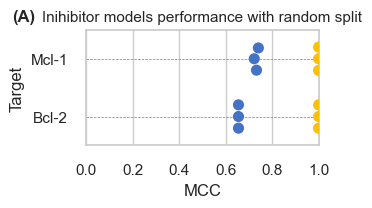

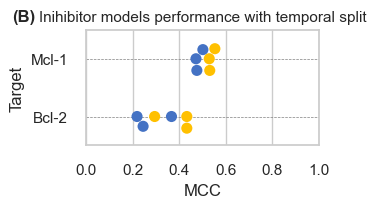

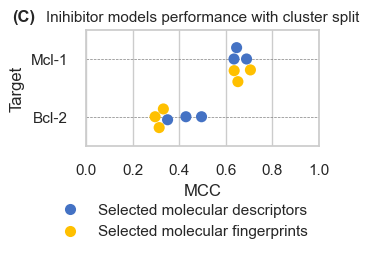

In [28]:
for split in splitting_methods:

    read_file_name =f"metrics/{split}_top3_models_target_test_metrics_2.csv"
    df = pd.read_csv(read_file_name, index_col=0)

    df['Feature'] = df['Feature'].replace({'MD': 'Selected molecular descriptors', 'FP': 'Selected molecular fingerprints',})

    #Visualize Top3
    sns.set_theme(style="whitegrid", palette="muted")


    plt.figure(figsize=(2, 3)) 
    plt.xlim(0, 1)

    horizontal_lines = [0, 1]
    desired_order = ["Selected molecular descriptors",'Selected molecular fingerprints']
    custom_colors = ['#4472C4','#FFC000']

    # Add horizontal guidelines
    for val in horizontal_lines:
        plt.axhline(val, color='gray', linestyle='--', linewidth=0.5)

  # Adjust marker size
    ax.set(ylabel="")

    ax.minorticks_on()
    ax.tick_params(which="both", bottom=True)


    plt.title('Inihibitor models performance with cluster split', fontsize=11)

    if split =="random": 
        ax = sns.swarmplot(data=df, x="MCC", y="Target", hue="Feature", size=8, palette=custom_colors, hue_order=desired_order, legend=False) 
        plt.title('Inihibitor models performance with random split', fontsize=11)
        plt.text(-0.32, -0.65, "(A)", fontsize=12, fontweight='bold')
    elif split =="temporal":
        ax = sns.swarmplot(data=df, x="MCC", y="Target", hue="Feature", size=8, palette=custom_colors, hue_order=desired_order, legend=False) 
        plt.title('Inihibitor models performance with temporal split', fontsize=11)
        plt.text(-0.32, -0.65, "(B)", fontsize=12, fontweight='bold')
    elif split =="cluster":
        ax = sns.swarmplot(data=df, x="MCC", y="Target", hue="Feature", size=8, palette=custom_colors, hue_order=desired_order, legend=True) 
        plt.title('Inihibitor models performance with cluster split', fontsize=11)
        plt.text(-0.32, -0.65, "(C)", fontsize=12, fontweight='bold')
        plt.legend(bbox_to_anchor=(0.41, -0.38), loc='upper center', ncol=1, frameon=False)


    plt.gcf().set_size_inches(3, 1.5)

    fig_name=f'inhibitor_{split}.svg'
    plt.savefig(fig_name, bbox_inches='tight')
    plt.show()